In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder \
    .appName("APP_1") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()

In [13]:
# try:
spark.stop()
# except:
#     pass

In [2]:
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

Rows: 32000204
Unique users: 200948
Unique Movies: 84432


In [3]:
# Select first n unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows: 154972
Unique users: 1000
Unique Movies: 11459


In [4]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [5]:
# Split df_final into 10 random parts (equal fractions)
fractions = [0.1] * 5   # 10 equal splits
splits = df_final.randomSplit(fractions, seed=42)

for i, part in enumerate(splits):
    n_users = part.select("user").distinct().count()
    n_movies = part.select("movie").distinct().count()
    print(f"Split {i+1}: {n_users} unique users, {n_movies} unique movies, {part.count()} rows")

Split 1: 999 unique users, 6188 unique movies, 31175 rows
Split 2: 1000 unique users, 6148 unique movies, 31020 rows
Split 3: 1000 unique users, 6140 unique movies, 30955 rows
Split 4: 999 unique users, 6119 unique movies, 30677 rows
Split 5: 998 unique users, 6232 unique movies, 31145 rows


In [6]:
for i, part in enumerate(splits):
    row = part.limit(1).collect() # Limit to one row and collect brings row from spark to python
    print(f"Model {i+1} sample row: {row}")

Model 1 sample row: [Row(user=0.0, movie=7.0, rating_scaled=1.0)]
Model 2 sample row: [Row(user=0.0, movie=3.0, rating_scaled=0.8)]
Model 3 sample row: [Row(user=0.0, movie=1.0, rating_scaled=1.0)]
Model 4 sample row: [Row(user=0.0, movie=0.0, rating_scaled=1.0)]
Model 5 sample row: [Row(user=0.0, movie=2.0, rating_scaled=1.0)]


In [6]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [7]:
import torch

all_data = []

for i, part in enumerate(splits):
    print(f"\n=== Processing Split {i+1} ===")
   
    train_df, test_df = part.randomSplit([0.8, 0.2], seed=42)
    print("split done")
    # Convert to Pandas
    train_pd = train_df.toPandas()
    test_pd = test_df.toPandas()
    print("split2 done")
    # Make sure indices are integers
    train_pd["user"] = train_pd["user"].astype(int)
    train_pd["movie"] = train_pd["movie"].astype(int)
    test_pd["user"] = test_pd["user"].astype(int)
    test_pd["movie"] = test_pd["movie"].astype(int)
    print("split3 done")
    # Convert to torch tensors
    X_train = torch.tensor(train_pd[["user", "movie"]].values, dtype=torch.long)  # for embedding
    y_train = torch.tensor(train_pd["rating_scaled"].values, dtype=torch.float)  # for MSE loss

    X_test = torch.tensor(test_pd[["user", "movie"]].values, dtype=torch.long)
    y_test = torch.tensor(test_pd["rating_scaled"].values, dtype=torch.float)

    # Print stats
    print("Train count:", X_train.shape[0], "| Train labels:", y_train.shape[0])
    print("Test count:", X_test.shape[0], "| Test labels:", y_test.shape[0])

    all_data.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    })



=== Processing Split 1 ===
split done
split2 done
split3 done
Train count: 24961 | Train labels: 24961
Test count: 6214 | Test labels: 6214

=== Processing Split 2 ===
split done
split2 done
split3 done
Train count: 24840 | Train labels: 24840
Test count: 6180 | Test labels: 6180

=== Processing Split 3 ===
split done
split2 done
split3 done
Train count: 24790 | Train labels: 24790
Test count: 6165 | Test labels: 6165

=== Processing Split 4 ===
split done
split2 done
split3 done
Train count: 24573 | Train labels: 24573
Test count: 6104 | Test labels: 6104

=== Processing Split 5 ===
split done
split2 done
split3 done
Train count: 24937 | Train labels: 24937
Test count: 6208 | Test labels: 6208


In [8]:
from torch.utils.data import TensorDataset, DataLoader

all_loaders = []  

for i, d in enumerate(all_data):
    # Create TensorDataset
    train_dataset = TensorDataset(d["X_train"], d["y_train"])
    test_dataset = TensorDataset(d["X_test"], d["y_test"])

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,drop_last=True)

    # Save loaders for later training
    all_loaders.append({
        "train_loader": train_loader,
        "test_loader": test_loader
    })

print(f"\nCreated DataLoaders for {len(all_loaders)} splits")


Created DataLoaders for 5 splits


In [12]:
tensor_splits = []
for ld in all_loaders:
    tr_ds = ld["train_loader"].dataset
    te_ds = ld["test_loader"].dataset
    # expects TensorDataset(X, y) where X shape (N,2) [user, movie]
    X_train, y_train = tr_ds.tensors[0].clone(), tr_ds.tensors[1].clone()
    X_test,  y_test  = te_ds.tensors[0].clone(), te_ds.tensors[1].clone()
    tensor_splits.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_test":  X_test,
        "y_test":  y_test
    })

torch.save(tensor_splits, "splits.pt")
print("Saved splits.pt with", len(tensor_splits), "splits")


Saved splits.pt with 5 splits


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   #n_users * emb_dim = 1000 * 16 = 16000
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  #n_movies * emb_dim = 11459 * 16 = 183,344
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), # user+movie embeddings concatenated 32 * 16 + 16 = 528
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  # 16 + 1 = 17
            nn.ReLU()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)

        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)

        # Pass through MLP
        return self.mlp(x).squeeze()


In [11]:
loss_fn = nn.MSELoss() # regression on ratings

In [12]:
def adam(parameter, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state


**Runs 1-Experiment**


================ Stage 1: Training Node 1 on Split 1 ================
Node 1 | Epoch 2/10 | Train Loss: 0.0536, Train RMSE: 0.2316 | Test Loss: 0.0507, Test RMSE: 0.2252
Node 1 | Epoch 4/10 | Train Loss: 0.0480, Train RMSE: 0.2190 | Test Loss: 0.0493, Test RMSE: 0.2221
Node 1 | Epoch 6/10 | Train Loss: 0.0448, Train RMSE: 0.2118 | Test Loss: 0.0545, Test RMSE: 0.2335
Node 1 | Epoch 8/10 | Train Loss: 0.0425, Train RMSE: 0.2063 | Test Loss: 0.0475, Test RMSE: 0.2180
Node 1 | Epoch 10/10 | Train Loss: 0.0415, Train RMSE: 0.2037 | Test Loss: 0.0456, Test RMSE: 0.2135

================ Stage 1: Training Node 2 on Split 2 ================
Node 2 | Epoch 2/10 | Train Loss: 0.0546, Train RMSE: 0.2336 | Test Loss: 0.0547, Test RMSE: 0.2338
Node 2 | Epoch 4/10 | Train Loss: 0.0486, Train RMSE: 0.2204 | Test Loss: 0.0471, Test RMSE: 0.2170
Node 2 | Epoch 6/10 | Train Loss: 0.0454, Train RMSE: 0.2132 | Test Loss: 0.0482, Test RMSE: 0.2195
Node 2 | Epoch 8/10 | Train Loss: 0.0428, Train RMSE: 0.2

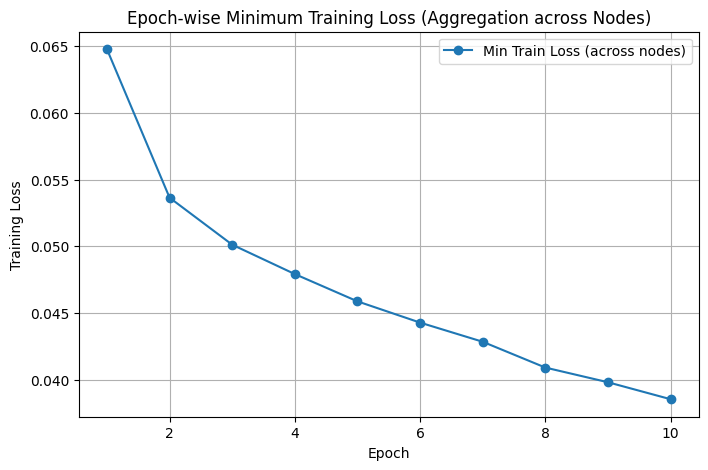

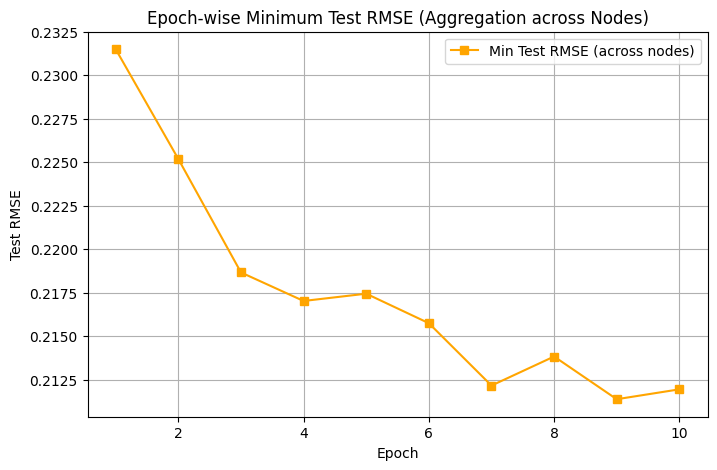

In [14]:
import copy
import matplotlib.pyplot as plt

# ---------- Settings ----------
epochs_stage1 = 10
all_candidates_stage1 = []  # store every node's per-epoch stats
min_train_curve = []        # aggregated minimum train loss after each epoch
min_test_rmse_curve = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

# ---------- Stage 1: Train 5 nodes on dataset splits ----------
for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
    print(f"\n================ Stage 1: Training Node {i} on Split {i} ================")

    node = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)
    m_state, v_state, t = {}, {}, 0

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    # Per-epoch storage
    train_losses_epoch = []
    test_losses_epoch = []
    train_rmses_epoch = []
    test_rmses_epoch = []
    epoch_states = []

    for epoch in range(epochs_stage1):
        # ---------- Training ----------
        node.train()
        total_sq_error, total_samples = 0, 0
        total_loss = 0

        for X_batch, y_batch in train_loader:
            preds = node(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())

            node.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(node.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Testing ----------
        node.eval()
        total_sq_error, total_samples, total_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Save per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(node.state_dict())
        
        if (epoch + 1) % 2 == 0:
            print(f"Node {i} | Epoch {epoch+1}/{epochs_stage1} | "
                f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
                f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")


    # ---------- Store all info for this node ----------
    all_candidates_stage1.append({
        "node": i,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states
    })

# ---------- Aggregation (MIN across nodes for each epoch) ----------
for epoch in range(epochs_stage1):
    min_loss = min(node["train_losses"][epoch] for node in all_candidates_stage1)
    min_train_curve.append(min_loss)
    
    min_test_rmse = min(node["test_rmses"][epoch] for node in all_candidates_stage1)
    min_test_rmse_curve.append(min_test_rmse)

# ---------- Plot Train Loss ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), min_train_curve, marker="o", label="Min Train Loss (across nodes)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Minimum Training Loss (Aggregation across Nodes)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), min_test_rmse_curve, marker="s", color="orange", label="Min Test RMSE (across nodes)")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Minimum Test RMSE (Aggregation across Nodes)")
plt.legend()
plt.grid(True)
plt.show()

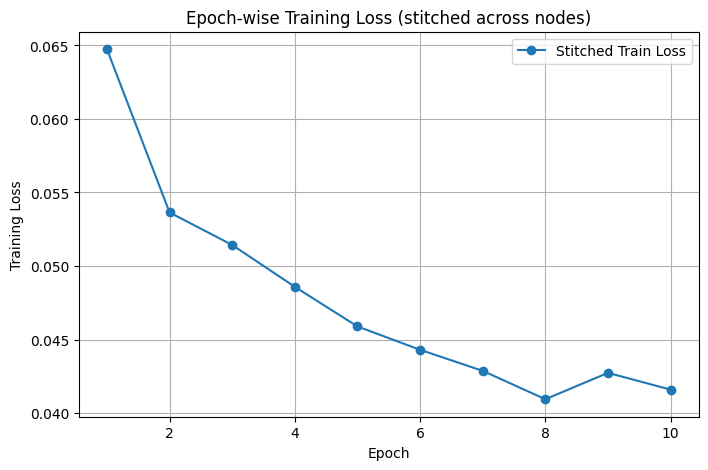

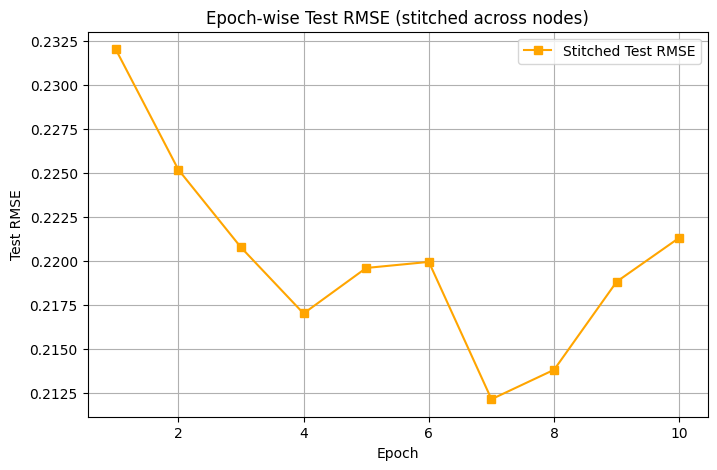

In [20]:
# ---------- Aggregation (Stitch node curves sequentially) ----------
stitched_train_curve = []
stitched_test_rmse_curve = []

num_nodes = len(all_candidates_stage1)
epochs_per_node = epochs_stage1 // num_nodes  # epochs assigned per node

for node_idx, node in enumerate(all_candidates_stage1):
    # figure out which slice of this node corresponds to its global epoch slot
    start = node_idx * epochs_per_node
    end = start + epochs_per_node
    
    stitched_train_curve.extend(node["train_losses"][start:end])
    stitched_test_rmse_curve.extend(node["test_rmses"][start:end])

# Global x-axis: 1..epochs_stage1
x_epochs = list(range(1, epochs_stage1 + 1))

# ---------- Plot Training Loss ----------
plt.figure(figsize=(8,5))
plt.plot(x_epochs, stitched_train_curve, marker="o", label="Stitched Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Training Loss (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(x_epochs, stitched_test_rmse_curve, marker="s", color="orange", label="Stitched Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Test RMSE (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import utils

# Save the aggregated curves instead of all node details
aggregated_curves = {
    "min_train_curve": min_train_curve,
    "min_test_rmse_curve": min_test_rmse_curve,
    "stitched_test_rmse_curve": stitched_test_rmse_curve,
    "stitched_train_curve": stitched_train_curve
}

utils.save_results("results/data_split.pkl", aggregated_curves)


**Runs N-Experiment**


================ RUN 1/5 ================

--- Stage 1: Training Node 1 on Split 1 ---
Node 1 | Epoch 2/10 | Train Loss: 0.0545, Train RMSE: 0.2335 | Test Loss: 0.0518, Test RMSE: 0.2276
Node 1 | Epoch 4/10 | Train Loss: 0.0474, Train RMSE: 0.2178 | Test Loss: 0.0468, Test RMSE: 0.2164
Node 1 | Epoch 6/10 | Train Loss: 0.0432, Train RMSE: 0.2078 | Test Loss: 0.0462, Test RMSE: 0.2149
Node 1 | Epoch 8/10 | Train Loss: 0.0403, Train RMSE: 0.2007 | Test Loss: 0.0443, Test RMSE: 0.2104
Node 1 | Epoch 10/10 | Train Loss: 0.0386, Train RMSE: 0.1964 | Test Loss: 0.0447, Test RMSE: 0.2113

--- Stage 1: Training Node 2 on Split 2 ---
Node 2 | Epoch 2/10 | Train Loss: 0.0541, Train RMSE: 0.2327 | Test Loss: 0.0490, Test RMSE: 0.2213
Node 2 | Epoch 4/10 | Train Loss: 0.0476, Train RMSE: 0.2182 | Test Loss: 0.0476, Test RMSE: 0.2181
Node 2 | Epoch 6/10 | Train Loss: 0.0435, Train RMSE: 0.2086 | Test Loss: 0.0451, Test RMSE: 0.2123
Node 2 | Epoch 8/10 | Train Loss: 0.0408, Train RMSE: 0.2020 | Tes

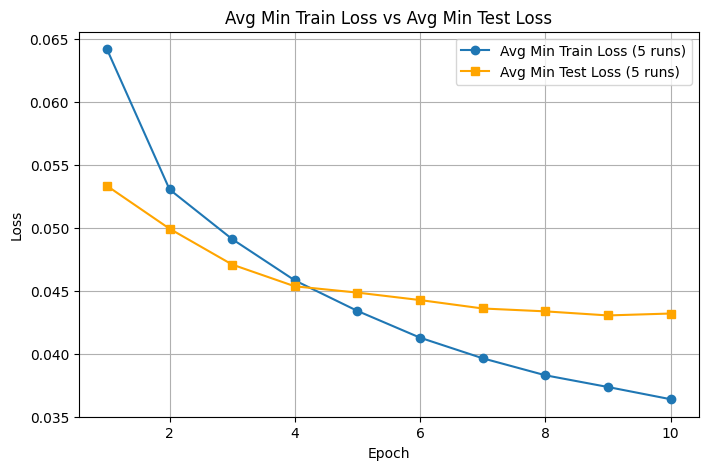

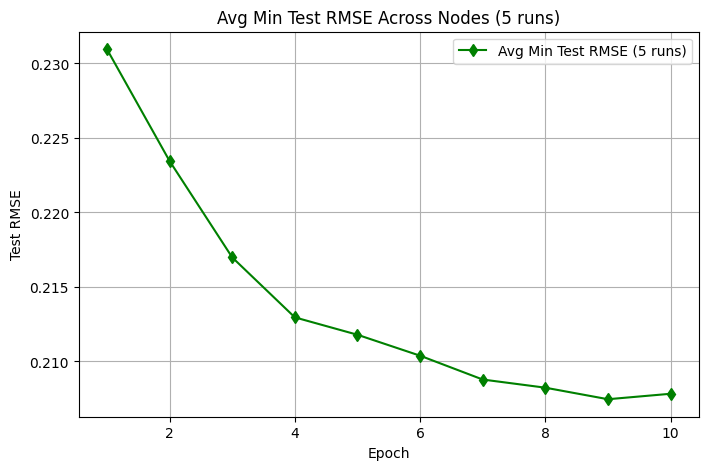

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------- Settings ----------
epochs_stage1 = 10
n_runs = 5   # repeat experiment 5 times

# Store aggregated curves (min across nodes per run)
all_runs_min_train = []
all_runs_min_test_loss = []
all_runs_min_test_rmse = []

# Store *all* per-run losses/RMSEs (like your base code)
all_runs_train_losses = []
all_runs_test_losses = []
all_runs_train_rmses = []
all_runs_test_rmses = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    all_candidates_stage1 = []  # store every node's stats in this run

    # ---------- Stage 1: Train nodes on dataset splits ----------
    for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
        print(f"\n--- Stage 1: Training Node {i} on Split {i} ---")

        node = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)
        m_state, v_state, t = {}, {}, 0

        train_loader = loaders["train_loader"]
        test_loader = loaders["test_loader"]

        # Per-epoch storage
        train_losses_epoch, test_losses_epoch = [], []
        train_rmses_epoch, test_rmses_epoch = [], []
        epoch_states = []

        for epoch in range(epochs_stage1):
            # ---------- Training ----------
            node.train()
            total_sq_error, total_samples, total_loss = 0, 0, 0
            for X_batch, y_batch in train_loader:
                preds = node(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())

                node.zero_grad()
                loss.backward()
                t += 1
                m_state, v_state = adam(node.parameters(), m_state, v_state, t)

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

            train_loss = total_loss / len(train_loader)
            train_rmse = (total_sq_error / total_samples) ** 0.5

            # ---------- Testing ----------
            node.eval()
            total_sq_error, total_samples, total_loss = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    preds = node(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
                    loss = loss_fn(preds, y_batch.float())

                    total_loss += loss.item()
                    total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                    total_samples += len(y_batch)

            test_loss = total_loss / len(test_loader)
            test_rmse = (total_sq_error / total_samples) ** 0.5

            # ---------- Save per-epoch stats ----------
            train_losses_epoch.append(train_loss)
            test_losses_epoch.append(test_loss)
            train_rmses_epoch.append(train_rmse)
            test_rmses_epoch.append(test_rmse)
            epoch_states.append(node.state_dict())

            if (epoch + 1) % 2 == 0:
                print(f"Node {i} | Epoch {epoch+1}/{epochs_stage1} | "
                      f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
                      f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---------- Store all info for this node ----------
        all_candidates_stage1.append({
            "node": i,
            "train_losses": train_losses_epoch,
            "test_losses": test_losses_epoch,
            "train_rmses": train_rmses_epoch,
            "test_rmses": test_rmses_epoch,
            "epoch_states": epoch_states
        })

    # ---------- Aggregation (MIN across nodes for each epoch) ----------
    min_train_curve = [min(node["train_losses"][epoch] for node in all_candidates_stage1)
                       for epoch in range(epochs_stage1)]
    min_test_loss_curve = [min(node["test_losses"][epoch] for node in all_candidates_stage1)
                           for epoch in range(epochs_stage1)]
    min_test_rmse_curve = [min(node["test_rmses"][epoch] for node in all_candidates_stage1)
                           for epoch in range(epochs_stage1)]

    # Save results for this run
    all_runs_min_train.append(min_train_curve)
    all_runs_min_test_loss.append(min_test_loss_curve)
    all_runs_min_test_rmse.append(min_test_rmse_curve)

    # Also save all (representative Node 1)
    all_runs_train_losses.append(all_candidates_stage1[0]["train_losses"])
    all_runs_test_losses.append(all_candidates_stage1[0]["test_losses"])
    all_runs_train_rmses.append(all_candidates_stage1[0]["train_rmses"])
    all_runs_test_rmses.append(all_candidates_stage1[0]["test_rmses"])

# ---------- Average over Runs ----------
avg_min_train = np.mean(all_runs_min_train, axis=0)
avg_min_test_loss = np.mean(all_runs_min_test_loss, axis=0)

avg_min_test_rmse = np.mean(all_runs_min_test_rmse, axis=0)

avg_train_losses = np.mean(all_runs_train_losses, axis=0)
avg_test_losses = np.mean(all_runs_test_losses, axis=0)
avg_train_rmses = np.mean(all_runs_train_rmses, axis=0)
avg_test_rmses = np.mean(all_runs_test_rmses, axis=0)

# ---------- Plot ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), avg_min_train, marker="o", label="Avg Min Train Loss (5 runs)")
plt.plot(range(1, epochs_stage1+1), avg_min_test_loss, marker="s", color="orange", label="Avg Min Test Loss (5 runs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Avg Min Train Loss vs Avg Min Test Loss")
plt.legend()
plt.grid(True)
plt.show()



In [33]:
avg_min_test_loss = list(avg_min_test_loss)
print(type(avg_min_test_loss))


<class 'list'>


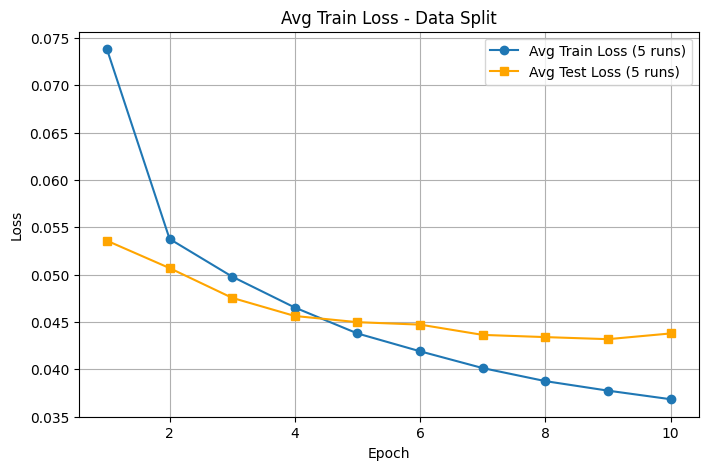

In [27]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), avg_train_losses, marker="o", label="Avg Train Loss (5 runs)")
plt.plot(range(1, epochs_stage1+1), avg_test_losses, marker="s", color="orange", label="Avg Test Loss (5 runs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Avg Train Loss - Data Split")
plt.legend()
plt.grid(True)
plt.show()



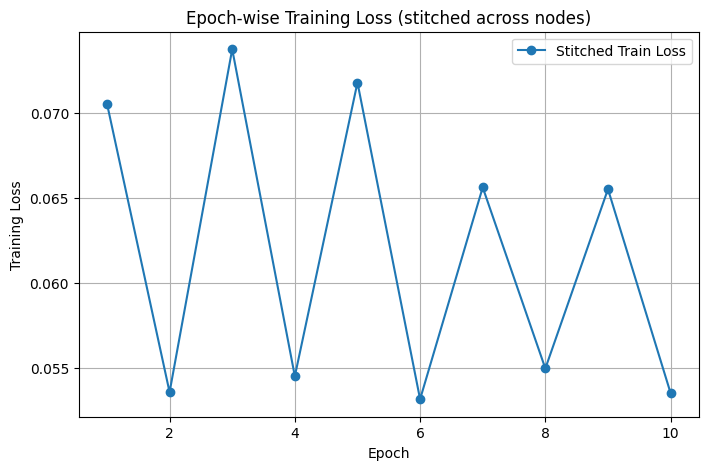

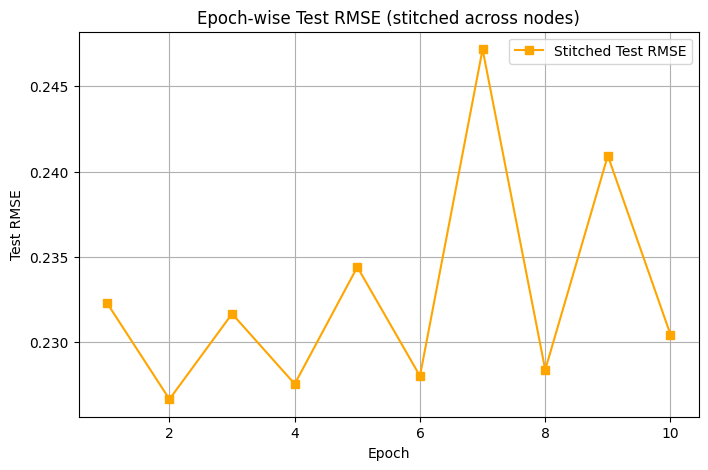

In [ ]:
# ---------- Aggregation (Stitch node curves sequentially) ----------
stitched_train_curve = []
stitched_test_rmse_curve = []

num_nodes = len(all_candidates_stage1)
epochs_per_node = epochs_stage1 // num_nodes  # Epochs per node


for node_idx, node in enumerate(all_candidates_stage1):
    start = node_idx * epochs_per_node
    end = start + epochs_per_node
    
    stitched_train_curve.extend(node["train_losses"][:epochs_per_node])
    stitched_test_rmse_curve.extend(node["test_rmses"][:epochs_per_node])


plt.figure(figsize=(8,5))
plt.plot(range(1, len(stitched_train_curve)+1), stitched_train_curve, marker="o", label="Stitched Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Training Loss (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(stitched_test_rmse_curve)+1), stitched_test_rmse_curve, marker="s", color="orange", label="Stitched Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Test RMSE (stitched across nodes)")
plt.legend()
plt.grid(True)
plt.show()



In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------- Settings ----------
epochs_stage1 = 10

# Store aggregated curves (min across nodes)
min_train_curve = []
min_test_loss_curve = []
min_test_rmse_curve = []

# Store *all* per-node losses/RMSEs
all_candidates_stage1 = []

# Global user/movie count (from Spark)
n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

print("\n================ SINGLE RUN ================")

# ---------- Stage 1: Train nodes on dataset splits ----------
for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
    print(f"\n--- Stage 1: Training Node {i} on Split {i} ---")

    node = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)
    m_state, v_state, t = {}, {}, 0

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    # Per-epoch storage
    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []
    epoch_states = []

    for epoch in range(epochs_stage1):
        # ---------- Training ----------
        node.train()
        total_sq_error, total_samples, total_loss = 0, 0, 0
        for X_batch, y_batch in train_loader:
            preds = node(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())

            node.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(node.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Testing ----------
        node.eval()
        total_sq_error, total_samples, total_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Save per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(node.state_dict())

        if (epoch + 1) % 2 == 0:
            print(f"Node {i} | Epoch {epoch+1}/{epochs_stage1} | "
                  f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

    # ---------- Store all info for this node ----------
    all_candidates_stage1.append({
        "node": i,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states
    })

# ---------- Aggregation Placeholder (currently MIN) ----------
min_train_loss_curve = [min(node["train_losses"][epoch] for node in all_candidates_stage1)
                   for epoch in range(epochs_stage1)]
min_test_loss_curve = [min(node["test_losses"][epoch] for node in all_candidates_stage1)
                       for epoch in range(epochs_stage1)]



print("\n✅ Data ready for PSO-based aggregation and broadcast.")



================ SINGLE RUN ================

--- Stage 1: Training Node 1 on Split 1 ---
Node 1 | Epoch 2/10 | Train Loss: 0.0540, Train RMSE: 0.2323 | Test Loss: 0.0488, Test RMSE: 0.2209
Node 1 | Epoch 4/10 | Train Loss: 0.0466, Train RMSE: 0.2159 | Test Loss: 0.0457, Test RMSE: 0.2139
Node 1 | Epoch 6/10 | Train Loss: 0.0416, Train RMSE: 0.2039 | Test Loss: 0.0440, Test RMSE: 0.2097
Node 1 | Epoch 8/10 | Train Loss: 0.0386, Train RMSE: 0.1964 | Test Loss: 0.0429, Test RMSE: 0.2072
Node 1 | Epoch 10/10 | Train Loss: 0.0366, Train RMSE: 0.1912 | Test Loss: 0.0447, Test RMSE: 0.2114

--- Stage 1: Training Node 2 on Split 2 ---
Node 2 | Epoch 2/10 | Train Loss: 0.0544, Train RMSE: 0.2331 | Test Loss: 0.0523, Test RMSE: 0.2287
Node 2 | Epoch 4/10 | Train Loss: 0.0487, Train RMSE: 0.2207 | Test Loss: 0.0478, Test RMSE: 0.2186
Node 2 | Epoch 6/10 | Train Loss: 0.0449, Train RMSE: 0.2119 | Test Loss: 0.0516, Test RMSE: 0.2273
Node 2 | Epoch 8/10 | Train Loss: 0.0423, Train RMSE: 0.2056 | 

In [24]:
import numpy as np
import torch
import copy

def aggregate_models_cpu(weights, node_states):
    """
    Aggregate node models using weighted average (CPU only).
    """
    n_nodes = len(node_states)
    agg_state = {}

    with torch.no_grad():
        for key in node_states[0].keys():
            agg_param = torch.zeros_like(node_states[0][key])
            for i in range(n_nodes):
                agg_param += weights[i] * node_states[i][key]
            agg_state[key] = agg_param

    return agg_state


def evaluate_model_cpu(global_state, model_template, test_loader, loss_fn):
    """
    Compute test loss for the aggregated model (RMSE removed).
    """
    model = copy.deepcopy(model_template)
    model.load_state_dict(global_state)
    model.eval()

    total_loss, total_samples = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item()
            total_samples += 1  # counting batches instead of samples is fine for average

    avg_loss = total_loss / total_samples
    return avg_loss


def pso_aggregate_cpu(all_candidates_stage1, model_template, test_loader, loss_fn,
                      num_particles=30, max_iters=50, w=0.7, c1=1.5, c2=1.5):
    """
    CPU-only PSO for distributed model aggregation using only test loss.
    """
    num_nodes = len(all_candidates_stage1)
    node_states = [node["epoch_states"][-1] for node in all_candidates_stage1]

    # Initialize particles and velocities
    particles = np.random.dirichlet(np.ones(num_nodes), size=num_particles)
    velocities = np.zeros_like(particles)
    pbest_positions = np.copy(particles)
    pbest_scores = np.full(num_particles, np.inf)

    gbest_position = None
    gbest_score = np.inf

    print("\n🚀 Starting CPU PSO Aggregation Optimization...")
    for iter_ in range(max_iters):
        for i in range(num_particles):
            weights = np.abs(particles[i])
            weights /= np.sum(weights)

            # Aggregate and evaluate
            global_state = aggregate_models_cpu(weights, node_states)
            test_loss = evaluate_model_cpu(global_state, model_template, test_loader, loss_fn)

            # Update personal best
            if test_loss < pbest_scores[i]:
                pbest_scores[i] = test_loss
                pbest_positions[i] = weights.copy()

            # Update global best
            if test_loss < gbest_score:
                gbest_score = test_loss
                gbest_position = weights.copy()

        # Update velocities and positions
        for i in range(num_particles):
            r1, r2 = np.random.rand(num_nodes), np.random.rand(num_nodes)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest_positions[i] - particles[i])
                + c2 * r2 * (gbest_position - particles[i])
            )
            particles[i] += velocities[i]

        if (iter_ + 1) % 10 == 0 or iter_ == 0:
            print(f"Iteration {iter_+1}/{max_iters} | Best Test Loss: {gbest_score:.4f}")

    # Final aggregation using the best weights
    final_state = aggregate_models_cpu(gbest_position, node_states)
    final_loss = evaluate_model_cpu(final_state, model_template, test_loader, loss_fn)

    print("\n✅ CPU PSO Aggregation Completed!")
    print(f"🌍 Global Best Test Loss: {gbest_score:.4f}, Final Loss: {final_loss:.4f}")
    print(f"🔹 Optimal Weights per Node: {np.round(gbest_position, 4)}")

    return final_state, gbest_position, gbest_score


In [25]:
# Initialize a fresh model template
model_template = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)

# Pick a test loader (node 1, for example)
global_test_loader = all_loaders[0]["test_loader"]

# Run CPU PSO aggregation
global_state, best_weights, best_loss = pso_aggregate_cpu(
    all_candidates_stage1,
    model_template,
    global_test_loader,
    loss_fn,
    num_particles=50,
    max_iters=40
)



🚀 Starting CPU PSO Aggregation Optimization...
Iteration 1/40 | Best Test Loss: 0.0459
Iteration 10/40 | Best Test Loss: 0.0440
Iteration 20/40 | Best Test Loss: 0.0440
Iteration 30/40 | Best Test Loss: 0.0440
Iteration 40/40 | Best Test Loss: 0.0440

✅ CPU PSO Aggregation Completed!
🌍 Global Best Test Loss: 0.0440, Final Loss: 0.0440
🔹 Optimal Weights per Node: [5.000e-04 1.000e-04 0.000e+00 2.150e-02 9.779e-01]
